ZhongXu has asked that I make him the HODs from the SHAMs I made him. This should be pretty straightforward so I'll do it quickly here.  

# GIVING UP, moving to ds14b

In [60]:
import numpy as np
import astropy
from pearce.mocks import cat_dict
from pearce.mocks.assembias_models.table_utils import compute_prim_haloprop_bins
import h5py
from os import path

In [61]:
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from itertools import cycle

In [62]:
config_fname = '/home/users/swmclau2/Git/pearce/bin/mcmc/nh_gg_sham_hsab_mcmc_config.yaml'

In [63]:
import yaml
with open(config_fname, 'r') as ymlfile:
    cfg = yaml.load(ymlfile)['data']

In [64]:
sim_cfg = cfg['sim']
obs_cfg = cfg['obs']
cov_cfg = cfg['cov']

In [65]:
#sim_cfg['simname'] = 'ds_14_b_sub'
#sim_cfg['halo_property'] = 'halo_vmax@mpeak'
sim_cfg['gal_property_fname'] = '/scratch/users/swmclau2/smf_dr72bright34_m7_lowm.dat'

In [66]:
cat = cat_dict[sim_cfg['simname']](**sim_cfg['sim_hps'])  # construct the specified catalog!

# TODO logspace
r_bins = obs_cfg['rbins']

obs = obs_cfg['obs']

if type(obs) is str:
    obs = [obs]

meas_cov_fname = cov_cfg['meas_cov_fname']
emu_cov_fname = cov_cfg['emu_cov_fname']
if type(emu_cov_fname) is str:
    emu_cov_fname = [emu_cov_fname]

assert len(obs) == len(emu_cov_fname), "Emu cov not same length as obs!"

n_bins = len(r_bins)-1
data = np.zeros((len(obs)*n_bins))
assert path.isfile(meas_cov_fname), "Invalid meas cov file specified"
try:
    cov = np.loadtxt(meas_cov_fname)
except ValueError:
    cov = np.load(meas_cov_fname)

assert cov.shape == (len(obs)*n_bins, len(obs)*n_bins), "Invalid meas cov shape."


In [80]:
cat.filenames[-1]

'/scratch/users/swmclau2/hlists/MDHR/hlist_1.00110.list'

In [82]:
from halotools.sim_manager import RockstarHlistReader

In [86]:
reader = RockstarHlistReader(cat.filenames[-1], cat.columns_to_keep, cat.cache_filenames[-1],\
                             cat.simname, 'rockstar', 0.0,  cat.version_name, cat.Lbox, cat.pmass,\
                             overwrite=False, header_char = '#')



The information about your ascii file and the metadata about the catalog 
have been processed and no exceptions were raised. 
Use the ``read_halocat`` method to read the ascii data, 
setting the write_to_disk and update_cache_log arguments as you like. 
See the docstring of the ``read_halocat`` method
for details about these options. 



In [87]:
reader.read_halocat(cat.columns_to_convert)


...Processing ASCII data of file: 
/scratch/users/swmclau2/hlists/MDHR/hlist_1.00110.list
 
Total number of rows in detected data = 16438267
Number of rows in detected header = 48 

... working on chunk 0 of 18
... working on chunk 1 of 18
... working on chunk 2 of 18
... working on chunk 3 of 18
... working on chunk 4 of 18
... working on chunk 5 of 18
... working on chunk 6 of 18
... working on chunk 7 of 18
... working on chunk 8 of 18
... working on chunk 9 of 18
... working on chunk 10 of 18
... working on chunk 11 of 18
... working on chunk 12 of 18
... working on chunk 13 of 18
... working on chunk 14 of 18
... working on chunk 15 of 18
... working on chunk 16 of 18
... working on chunk 17 of 18
Total runtime to read in ASCII = 12.9 minutes




In [89]:
reader.halo_table

halo_upid,halo_vacc,halo_vmax,halo_rs_klypin,halo_snapnum,halo_macc,halo_halfmass_scale,halo_y,halo_id,halo_x,halo_vx,halo_vy,halo_vz,halo_m200b,halo_rs,halo_rvir,halo_vpeak,halo_z,halo_mvir,halo_nfw_conc,halo_hostid
int64,float32,float32,float32,int64,float32,float32,float32,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64
-1,210300.0,1522.56,0.486617,42,159500.0,108100.0,478.527,733303403,20.6493,282.17,815.03,277.49,1.169e+15,0.512837,2.09695,137900.0,688.658,1.041e+15,4.08893,733303403
-1,90930.0,1447.71,0.544008,42,182000.0,115600.0,328.863,733018090,119.928,-621.74,-772.24,333.82,1.0083e+15,0.593102,2.02309,112800.0,612.199,9.351e+14,3.41103,733018090
-1,142800.0,1365.17,0.737135,42,345300.0,99720.0,290.435,733034970,34.4806,111.96,-487.09,-27.31,1.0533e+15,0.752988,1.95211,63760.0,660.022,8.401e+14,2.59249,733034970
-1,46020.0,1464.01,0.218795,42,49260.0,41620.0,389.727,733303551,0.43736,-130.27,-368.0,268.37,7.7247e+14,0.228817,1.8146,47730.0,655.748,6.748e+14,7.93037,733303551
-1,-2483.0,1360.74,0.279493,42,-23930.0,74800.0,485.214,735444141,171.419,-274.79,-200.48,478.96,7.2269e+14,0.309754,1.77302,87440.0,688.537,6.295e+14,5.72395,735444141
-1,16020.0,1294.13,0.340585,42,15480.0,48080.0,330.248,733035151,94.7808,-275.94,-170.96,-325.04,6.926e+14,0.34683,1.74283,44370.0,641.935,5.979e+14,5.02503,733035151
-1,42640.0,1275.64,0.374787,42,-9852.0,62450.0,290.607,733017946,62.4626,30.09,-1.4,168.15,6.5839e+14,0.368125,1.74112,85280.0,623.412,5.961e+14,4.72969,733017946
-1,127900.0,1265.65,0.340223,42,18770.0,60780.0,253.683,733035230,44.2488,196.94,233.45,45.58,6.385e+14,0.388069,1.70957,81810.0,654.622,5.643e+14,4.40532,733035230
-1,81700.0,1291.39,0.285035,42,24870.0,63390.0,468.582,735444356,184.141,-398.99,199.15,464.13,5.6973e+14,0.324384,1.69956,88690.0,685.308,5.544e+14,5.23935,735444356


In [67]:
#cat.load(sim_cfg['scale_factor'], **sim_cfg['sim_hps'])
#cat.populate()# will generate a mock for us to overwrite
gal_property = np.loadtxt(sim_cfg['gal_property_fname'])
halo_property_name = sim_cfg['halo_property']
min_ptcl = sim_cfg.get('min_ptcl', 200)
nd = float(sim_cfg['nd'])
scatter = float(sim_cfg['scatter'])

In [91]:
cat.h

0.7020000000000001

In [90]:
from AbundanceMatching import *
af =  AbundanceFunction(gal_property[:,0], gal_property[:,1], sim_cfg['af_hyps'], faint_end_first = sim_cfg['reverse'])
remainder = af.deconvolute(scatter, 20)
# apply min mass
halo_table = reader.halo_table#cat.halocat.halo_table#[cat.halocat.halo_table['halo_mvir']>min_ptcl*cat.pmass] 
nd_halos = calc_number_densities(halo_table[halo_property_name], cat.Lbox) #don't think this matters which one i choose here
catalog_w_nan = af.match(nd_halos, scatter)
n_obj_needed = int(nd*(cat.Lbox**3))
catalog = halo_table[~np.isnan(catalog_w_nan)]
sort_idxs = np.argsort(catalog)

In [69]:
np.all(cat.halocat.halo_table['halo_upid']==-1)

False

In [92]:
np.sum(halo_table['halo_upid'] == -1)

14565913

In [93]:
final_catalog = halo_table[~np.isnan(catalog_w_nan)][sort_idxs[:n_obj_needed]]

#final_catalog['x'] = final_catalog['halo_x']
#final_catalog['y'] = final_catalog['halo_y']
#final_catalog['z'] = final_catalog['halo_z']
#final_catalog['halo_upid'] = -1
# FYI cursed.
#cat.model.mock.galaxy_table = final_catalog
# TODO save sham hod "truth"

In [94]:
final_catalog.colnames

['halo_upid',
 'halo_vacc',
 'halo_vmax',
 'halo_rs_klypin',
 'halo_snapnum',
 'halo_macc',
 'halo_halfmass_scale',
 'halo_y',
 'halo_id',
 'halo_x',
 'halo_vx',
 'halo_vy',
 'halo_vz',
 'halo_m200b',
 'halo_rs',
 'halo_rvir',
 'halo_vpeak',
 'halo_z',
 'halo_mvir',
 'halo_nfw_conc',
 'halo_hostid']

In [95]:
from halotools.mock_observables import *

In [96]:
x, y, z = [final_catalog[c] for c in ['halo_x', 'halo_y', 'halo_z']]
pos = return_xyz_formatted_array(x, y, z, period=cat.Lbox)

In [97]:
xi_all = tpcf(pos / cat.h, r_bins, period=cat.Lbox / cat.h, num_threads=4,
                              estimator='Landy-Szalay')

In [98]:
xi_all

array([ -1.00000000e+00,  -1.00000000e+00,   2.34036457e+01,
         1.52151441e+02,   2.97679025e+02,   2.91343348e+02,
         1.93159382e+02,   1.09047017e+02,   5.26977826e+01,
         2.62023209e+01,   1.34719705e+01,   7.02559721e+00,
         3.58227506e+00,   1.87404796e+00,   1.03531472e+00,
         5.79425318e-01,   3.12589004e-01,   1.57569414e-01])

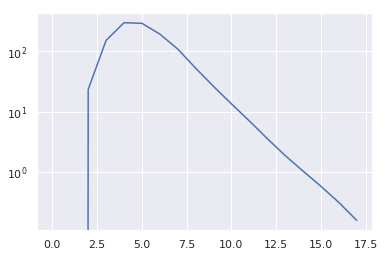

In [100]:
plt.plot(xi_all)
plt.yscale('log')

In [102]:
import h5py
f = h5py.File('/home/users/swmclau2/scratch/PearceMCMC/pearce_mcmc_nh_gg_sham_hsab.hdf5', 'r')

In [103]:
cov = f['cov'].value

In [105]:
np.savetxt('/home/users/swmclau2/Git/pearce/bin/shams/xigg_cov_mcmc.npy', cov)